In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd
import datasets
import os
import json
import math
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams["font.family"] = "Times New Roman"

In [3]:
# !wget -nc https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

In [4]:
font_prop = fm.FontProperties(fname='Times New Roman.ttf')
plt.rcParams['font.family'] = font_prop.get_name()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = [font_prop.get_name()] + plt.rcParams['font.serif']

### Name/Color mappings

Use same name/color maps across paper for consistency

In [51]:
COLOR_MAPPING = {
    'Normal': '#7fc97f',
    'De-duplicated': '#beaed4'
}
ATTACK_COLOR_MAPPING = {
#     'ref-gpt2': '#1b9e77',
    'loss': '#d95f02',
    'ref-stablelm-base-alpha-3b-v2': '#1b9e77',
    'min_k': '#e7298a',
    'zlib': '#7570b3',
    # 'ne': '#1f78b4'
}

ATTACK_MAP = {
    'ref-gpt2': 'Reference-based',
    'ref-stablelm-base-alpha-3b-v2': 'Reference-based',
    'loss': 'LOSS',
    'zlib': 'Zlib',
    'min_k': 'Min-k% Prob',
    'ne': 'Neighborhood'
}

# Picked using https://www.learnui.design/tools/data-color-picker.html#single
MODEL_SIZE_COLOR_MAPPING = {
    '1.4b': '#00d6ff',
    '2.8b': '#00a5cf',
    '6.9b': '#03779e',
    '12b':  '#004c6d'
}

MODEL_SIZES = {
    '160m': .16,
    '1.4b': 1.4,
    '2.8b': 2.8,
    '6.9b': 6.9,
    '12b': 12
}
NGRAM_COLOR = '#cc5090'

## Model Size

In [ ]:
from collections import defaultdict
# Pythia deduped data size exp
# MODEL_SIZE_COLOR_MAPPING = {
#     '160m': '#66a61e',
#     '1.4b': '#1b9e77',
#     '2.8b': '#d95f02',
#     '6.9b': '#7570b3',
#     '12b': '#e7298a'
# }

OLD_TO_NEW = {
    'ref_model_gpt2_lira_ratio_threshold': 'ref-gpt2',
    'likelihood_threshold': 'loss',
    'zlib_entropy_threshold': 'zlib',
    'min_prob_k': 'min_k'
}

DOMAIN_SUFFIX = "_ngram_13_<0.8_truncated"
DOMAIN_SUFFIX_LEN = len(DOMAIN_SUFFIX)

# Collect results for graphing
results_file = './mia_unified_mia_v5_ref_tab1_v2_results.json'
with open(results_file, 'r') as f:
    results = json.load(f)
    
# Reorganize results into a dictionary in the format domain -> duped or deduped -> attack -> model_size -> auc 
organized_results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for domain, results_per_model_size in results.items():
    domain = domain[:-DOMAIN_SUFFIX_LEN]
    for msr in results_per_model_size:
        model = msr['target']
        model_size = model.split('-')[1]
        dupe_state = "deduped" if "deduped" in model else "duped"
        for attack, performance in msr.items():
            if attack != 'target':
                attack_name = attack.split('_results.json')[0]
#                 old_attack_name = attack.split('_results.json')[0]
#                 attack_name = OLD_TO_NEW[old_attack_name]
                roc_auc = performance['roc_auc']
                organized_results[domain][dupe_state][attack_name][model_size] = roc_auc
                
print(organized_results.keys())
print(organized_results['arxiv'].keys())
print(organized_results['arxiv']['deduped'].keys())
# print(organized_results['arxiv']['deduped']['loss'].keys())

DOMAINS_OF_INTEREST = {
    'wikipedia_(en)': "Wikipedia",
    'github': "GitHub",
    'arxiv': "ArXiv",
    'hackernews': 'HackerNews'
}

# attacks_picked = ['loss', 'min_k']
attacks_picked = ['ref-stablelm-base-alpha-3b-v2']#, 'loss', 'zlib']


# DOMAINS_TO_YLIM = {
#     'wikipedia_(en)': (.48, .56),
#     'arxiv': (.48, .56),
#     'hackernews': (.48, .56),
#     'github': (.6, .77),
# }

DOMAINS_TO_YLIM = {
    'wikipedia_(en)': (.5, .7),
    'arxiv': (.48, .62),
    'hackernews': (.48, .62),
    'github': (.5, .7),
}
                
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 8, 'lines.linewidth': 3, 'axes.linewidth': 3})

# Create a figure and axis
fig, axs = plt.subplots(len(attacks_picked), len(DOMAINS_OF_INTEREST),
                        figsize=(5 * len(DOMAINS_OF_INTEREST), 4 * len(attacks_picked)),
                        gridspec_kw={'wspace':0.1,'hspace':0.1},
                        layout='constrained')

# Ensuring axs is always a 2D array
if len(attacks_picked) == 1:
    axs = np.expand_dims(axs, 0)
if len(DOMAINS_OF_INTEREST) == 1:
    axs = np.expand_dims(axs, 1)

# Plot the data with Seaborn
for i, domain in enumerate(DOMAINS_OF_INTEREST.keys()):
    model_sizes_sorted = sorted(MODEL_SIZES.items(), key=lambda x: x[1])
    model_names = [ms[0] for ms in model_sizes_sorted]
    model_sizes = [ms[1] for ms in model_sizes_sorted]
    print(model_sizes)
    y_loc = i
    
    for dupe_state, performance_per_attack in organized_results[domain].items():
        # Plot line for attack
        for j, att_pick in enumerate(attacks_picked):
            perf = [performance_per_attack[att_pick][ms] for ms in model_names]
            sns.lineplot(ax=axs[j, y_loc], x=model_sizes, y=perf, color=COLOR_MAPPING['De-duplicated' if dupe_state == 'deduped' else 'Normal'], marker='o')

    axs[0, y_loc].set_title(DOMAINS_OF_INTEREST[domain])
    for j, att_pick in enumerate(attacks_picked):
        axs[j, y_loc].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[j, y_loc].xaxis.set_ticks(np.arange(0, 14, 2))
        axs[j, y_loc].set_ylim(DOMAINS_TO_YLIM[domain]) 
        if y_loc == 0 and len(attacks_picked) > 1:
            axs[j, y_loc].set_ylabel(ATTACK_MAP[att_pick])

x_ax = fig.supxlabel('Model Size (B)')
y_ax = fig.supylabel('AUC ROC')


legend_lines, legend_names = [], []
for k, v in COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(k)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.1), # For single-row
              #loc='upper center', bbox_to_anchor=(0.5, 1.05), # For 4 rows
              borderaxespad=0, ncol=2, fontsize=18,
              facecolor='white', frameon=False)

# Save the figure
fig.savefig(f'model_size_ref_stable.pdf', bbox_inches='tight')

## Deduplication (needs ngram overlap of full_pile test set)

In [7]:
import argparse
import json 
import datasets
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

ngrams = ["ngram_7", "ngram_13", "ngram_4"]
base_dir = "/p/distinf/ngram/full_pile/"

subset_overlaps = defaultdict(lambda: defaultdict(dict))
for ngram in ngrams:
    shard_0 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram, "0", "test.jsonl.gz"), split="train") #, num_proc=8)#.filter(lambda x: x["meta"]["pile_set_name"].replace(" ", "_").replace("-", "_").lower() == subset, num_proc=8)
    print(shard_0)
    shard_1 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram, "1", "test.jsonl.gz"), split="train") #, num_proc=8)#.filter(lambda x: x["meta"]["pile_set_name"].replace(" ", "_").replace("-", "_").lower() == subset, num_proc=8)

    assert shard_0["original"][0] == shard_1["original"][0] and shard_0["original"][1] == shard_1["original"][1]
    for in0, in1 in tqdm(zip(shard_0, shard_1)):
        ngram_inclusion = np.array(in0["ngram_inclusion"][:200]) | np.array(in1["ngram_inclusion"][:200])
    
        subset = in0["meta"]["pile_set_name"].replace(" ", "_").replace("-", "_").lower()
        text = in0["original"]
        individual_ngram_overlap = np.mean(ngram_inclusion[:200])
        subset_overlaps[ngram][subset][text] = individual_ngram_overlap

Using custom data configuration default-a05f03cdb7fedd46
Found cached dataset json (/p/distinf/hf_cache/datasets/json/default-a05f03cdb7fedd46/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration default-3c9d2114a9d31c7b
Found cached dataset json (/p/distinf/hf_cache/datasets/json/default-3c9d2114a9d31c7b/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


Dataset({
    features: ['bff_contained_ngram_count_before_dedupe', 'meta', 'ngram_inclusion', 'original', 'text'],
    num_rows: 214584
})


214584it [04:07, 868.61it/s] 
Using custom data configuration default-adf8b77446c5c35d
Found cached dataset json (/p/distinf/hf_cache/datasets/json/default-adf8b77446c5c35d/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration default-336dcfd85ffbf9f9
Found cached dataset json (/p/distinf/hf_cache/datasets/json/default-336dcfd85ffbf9f9/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


Dataset({
    features: ['bff_contained_ngram_count_before_dedupe', 'meta', 'ngram_inclusion', 'original', 'text'],
    num_rows: 214584
})


181217it [03:29, 880.39it/s] 

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /p/distinf/hf_cache/datasets/json/default-e8f97a019be4f1d9/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


214584it [04:07, 866.44it/s] 


### Figure 4

wikipedia_(en)  mean:  0.3245262063579081  max:  1.0
github  mean:  0.769397877232716  max:  1.0
arxiv  mean:  0.3934611199636458  max:  1.0
hackernews  mean:  0.22629505350023285  max:  0.97


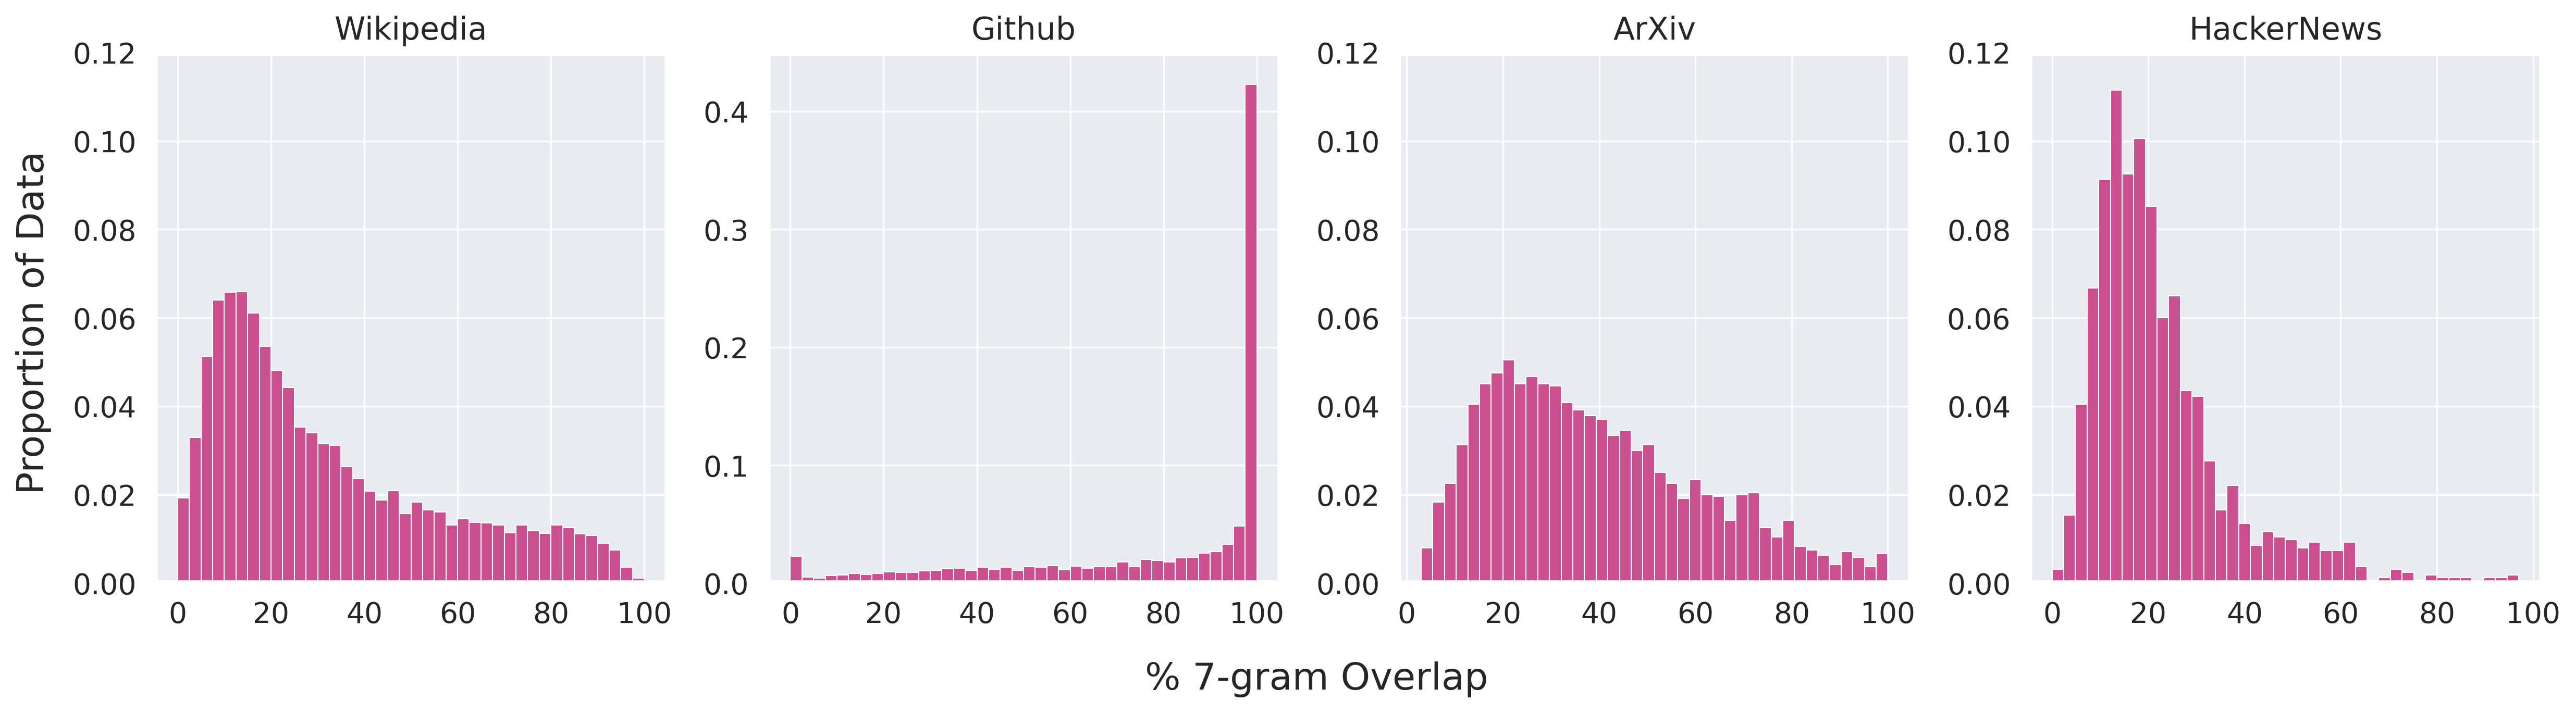

In [17]:
subsets = ["wikipedia_(en)", "github",  "arxiv", "hackernews"] #"pile_cc", "pubmed_central", "arxiv", "dm_mathematics", "hackernews", "full_pile"] #, "dm_mathematics"]#"pile_cc", "arxiv"]"gutenberg_(pg_19)" "pubmed_central",
ngrams = ["ngram_7"]#, "ngram_13"]
# Set Seaborn style
sns.set(style="darkgrid")
sns.set_context("paper",
                font_scale = 1.5,
                rc={
                    'lines.markersize': 5,
                    'lines.linewidth': 3,
                    'axes.linewidth': 3})

subset_color_map = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3', '#66a61e', '#a6761d', '#e6ab02', '#667668']
subset_name_map = ['Wikipedia', 'Github', 'ArXiv', 'HackerNews'] #'Pile CC', 'PubMed Central', 'ArXiv', 'DM Mathematics', 'HackerNews', 'Full Pile'] # 'Pile CC',  'ArXiv', 'Pubmed Central']
ngram_ylim = {
    'ngram_4': [(0,0.12),(0,0.52)],
    'ngram_7': [(0,0.12), (0,0.45)],
    'ngram_13': [(0,0.5),(0,0.69)] 
}
# for subset, scores in subset_overlaps['ngram_7'].items():
#     print(subset, " mean: ", np.mean(list(scores.values())), ", max: ", np.max(list(scores.values())))

# Create a figure and axis
fig, axs = plt.subplots(len(ngrams) * math.ceil(len(subsets) / 4),4, figsize=(16,4 * len(ngrams)  * math.ceil(len(subsets) / 4)),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, ngram in enumerate(ngrams):
    for j, subset in enumerate(subsets):
        x_loc, y_loc = i * math.ceil(len(subsets) / 4) + j//4, j % 4
        curr_axs = axs[j] if len(ngrams) * math.ceil(len(subsets) / 4) == 1 else axs[x_loc, y_loc]

        # Plot the histogram
        if subset == "full_pile":
            ino = {}
            for s in subset_overlaps[ngram].keys():
                ino.update(subset_overlaps[ngram][s])
        else:
            ino = subset_overlaps[ngram][subset]
        print(subset, " mean: ", np.mean(list(ino.values())), " max: ", np.max(list(ino.values())))
        hplt = sns.histplot(ax=curr_axs, data=100 * np.array(list(ino.values())), bins=40,
                            #facecolor=subset_color_map[j],
                            facecolor=NGRAM_COLOR,
                            stat='probability')
#         if x_loc == 0 and y_loc == 0:    
#             curr_axs.set_ylabel("7-gram")
#         elif x_loc == 1 and y_loc == 0:    
#             curr_axs.set_ylabel("13-gram")
#         else:
        curr_axs.set_ylabel(None)

        if i == 0:
            curr_axs.set_title(subset_name_map[j])
        #axs[x_loc, y_loc]
        curr_axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
        if subset == 'github' and False:
            curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            curr_axs.yaxis.set_ticks(np.arange(0, .45, .1))
        # 4 gram subset == 'github' or subset == 'dm_mathematics':
        # 7 gram subset == 'github':
        # 13 gram subset == 'pile_cc' or subset == 'full_pile' or subset == 'hackernews':
        if subset == 'github' or subset == 'dm_mathematics':
            curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            curr_axs.yaxis.set_ticks(np.arange(0, .45, .1))
            curr_axs.set_ylim(ngram_ylim[ngram][1])
        else:
            curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            curr_axs.set_ylim(ngram_ylim[ngram][0])
#         hplt.legend_.remove()
        # plt.hist(individual_ngram_overlap_values, bins=100, range=(0, 1))

x_ax = fig.supxlabel('% 7-gram Overlap', y=-.1) #'% Overlap'
y_ax = fig.supylabel('Proportion of Data', x=-.02)

# Save the histograms
plt.savefig("ngram_overlap_hist.pdf", bbox_inches='tight')

#### Figure 15

wikipedia_(en)  mean:  0.14608411088344395  max:  1.0
github  mean:  0.6587596661123698  max:  1.0
pile_cc  mean:  0.16703333312339036  max:  1.0
pubmed_central  mean:  0.13162588858769483  max:  1.0
arxiv  mean:  0.1617218384327186  max:  1.0
dm_mathematics  mean:  0.2271343050494534  max:  0.8
hackernews  mean:  0.05932437544066225  max:  0.94
full_pile  mean:  0.1982877415138188  max:  1.0


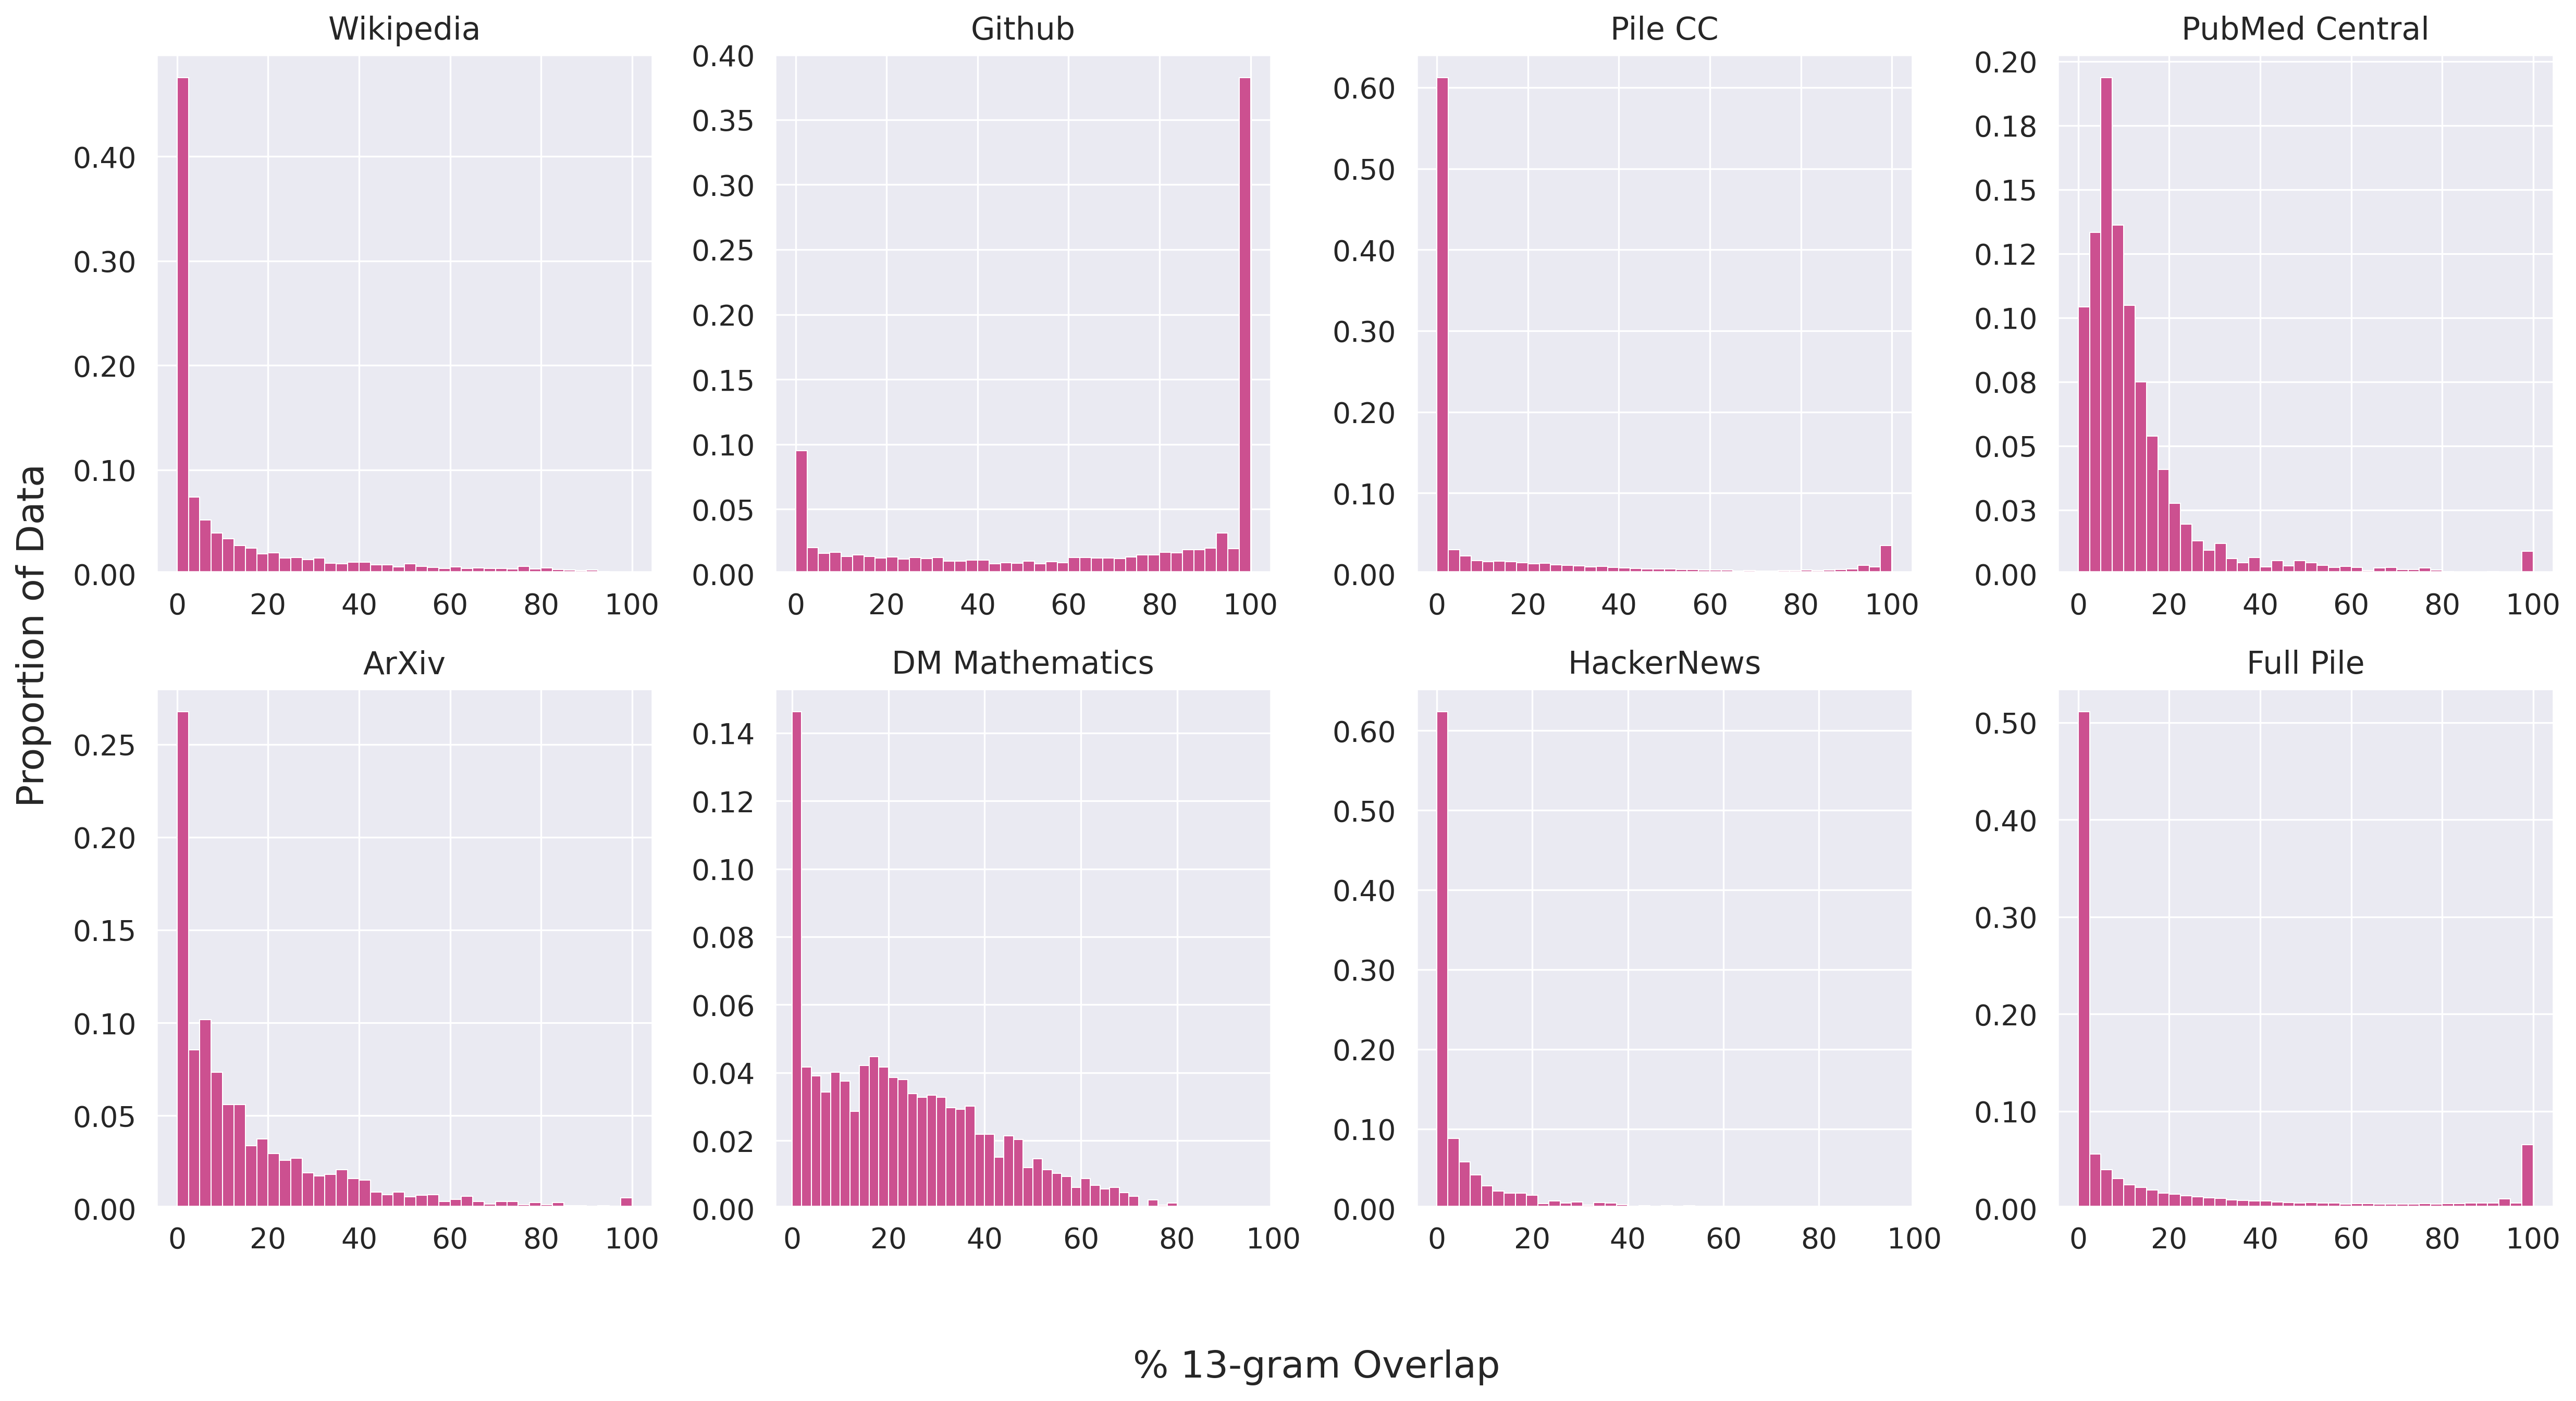

In [37]:
subsets = ["wikipedia_(en)", "github", "pile_cc", "pubmed_central", "arxiv", "dm_mathematics", "hackernews", "full_pile"] #, "dm_mathematics"]#"pile_cc", "arxiv"]"gutenberg_(pg_19)" "pubmed_central",
chosen_n = 13

ngrams = [f"ngram_{chosen_n}"]#, "ngram_13"]
# Set Seaborn style
sns.set(style="darkgrid")
sns.set_context("paper",
                font_scale = 1.5,
                rc={
                    'lines.markersize': 5,
                    'lines.linewidth': 3,
                    'axes.linewidth': 3})

subset_name_map = ['Wikipedia', 'Github', 'Pile CC', 'PubMed Central', 'ArXiv', 'DM Mathematics', 'HackerNews', 'Full Pile'] # 'Pile CC',  'ArXiv', 'Pubmed Central']
ngram_ylim = {
    'ngram_4': [(0,0.12),(0,0.52)],
    'ngram_7': [(0,0.12), (0,0.45)],
    'ngram_13': [(0,0.69),(0,0.69)] 
}
# for subset, scores in subset_overlaps['ngram_7'].items():
#     print(subset, " mean: ", np.mean(list(scores.values())), ", max: ", np.max(list(scores.values())))

# Create a figure and axis
fig, axs = plt.subplots(len(ngrams) * math.ceil(len(subsets) / 4),
                        4,
                        figsize=(16,4 * len(ngrams)  * math.ceil(len(subsets) / 4)),
                        gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, ngram in enumerate(ngrams):
    for j, subset in enumerate(subsets):
        x_loc, y_loc = i * math.ceil(len(subsets) / 4) + j//4, j % 4
        curr_axs = axs[j] if len(ngrams) * math.ceil(len(subsets) / 4) == 1 else axs[x_loc, y_loc]

        # Plot the histogram
        if subset == "full_pile":
            ino = {}
            for s in subset_overlaps[ngram].keys():
                ino.update(subset_overlaps[ngram][s])
        else:
            ino = subset_overlaps[ngram][subset]
        print(subset, " mean: ", np.mean(list(ino.values())), " max: ", np.max(list(ino.values())))
        hplt = sns.histplot(ax=curr_axs, data=100 * np.array(list(ino.values())), bins=40,
                            facecolor=NGRAM_COLOR,
                            stat='probability')
#         if x_loc == 0 and y_loc == 0:    
#             curr_axs.set_ylabel("7-gram")
#         elif x_loc == 1 and y_loc == 0:    
#             curr_axs.set_ylabel("13-gram")
#         else:
        curr_axs.set_ylabel(None)

        if i == 0:
            curr_axs.set_title(subset_name_map[j])
        #axs[x_loc, y_loc]
        curr_axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
#         if subset == 'github' and False:
        # curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        # curr_axs.yaxis.set_ticks(np.arange(0, .45, .1))
        # 4 gram subset == 'github' or subset == 'dm_mathematics':
        # 7 gram subset == 'github':
        # 13 gram
        curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # curr_axs.set_ylim(ngram_ylim[ngram][0])
#         hplt.legend_.remove()
        # plt.hist(individual_ngram_overlap_values, bins=100, range=(0, 1))

x_ax = fig.supxlabel(f'% {chosen_n}-gram Overlap', y=-.1) #'% Overlap'
y_ax = fig.supylabel('Proportion of Data', x=-.02)

# Save the histograms
plt.savefig(f"{chosen_n}-gram-overlap.pdf", bbox_inches='tight')

8596
8596


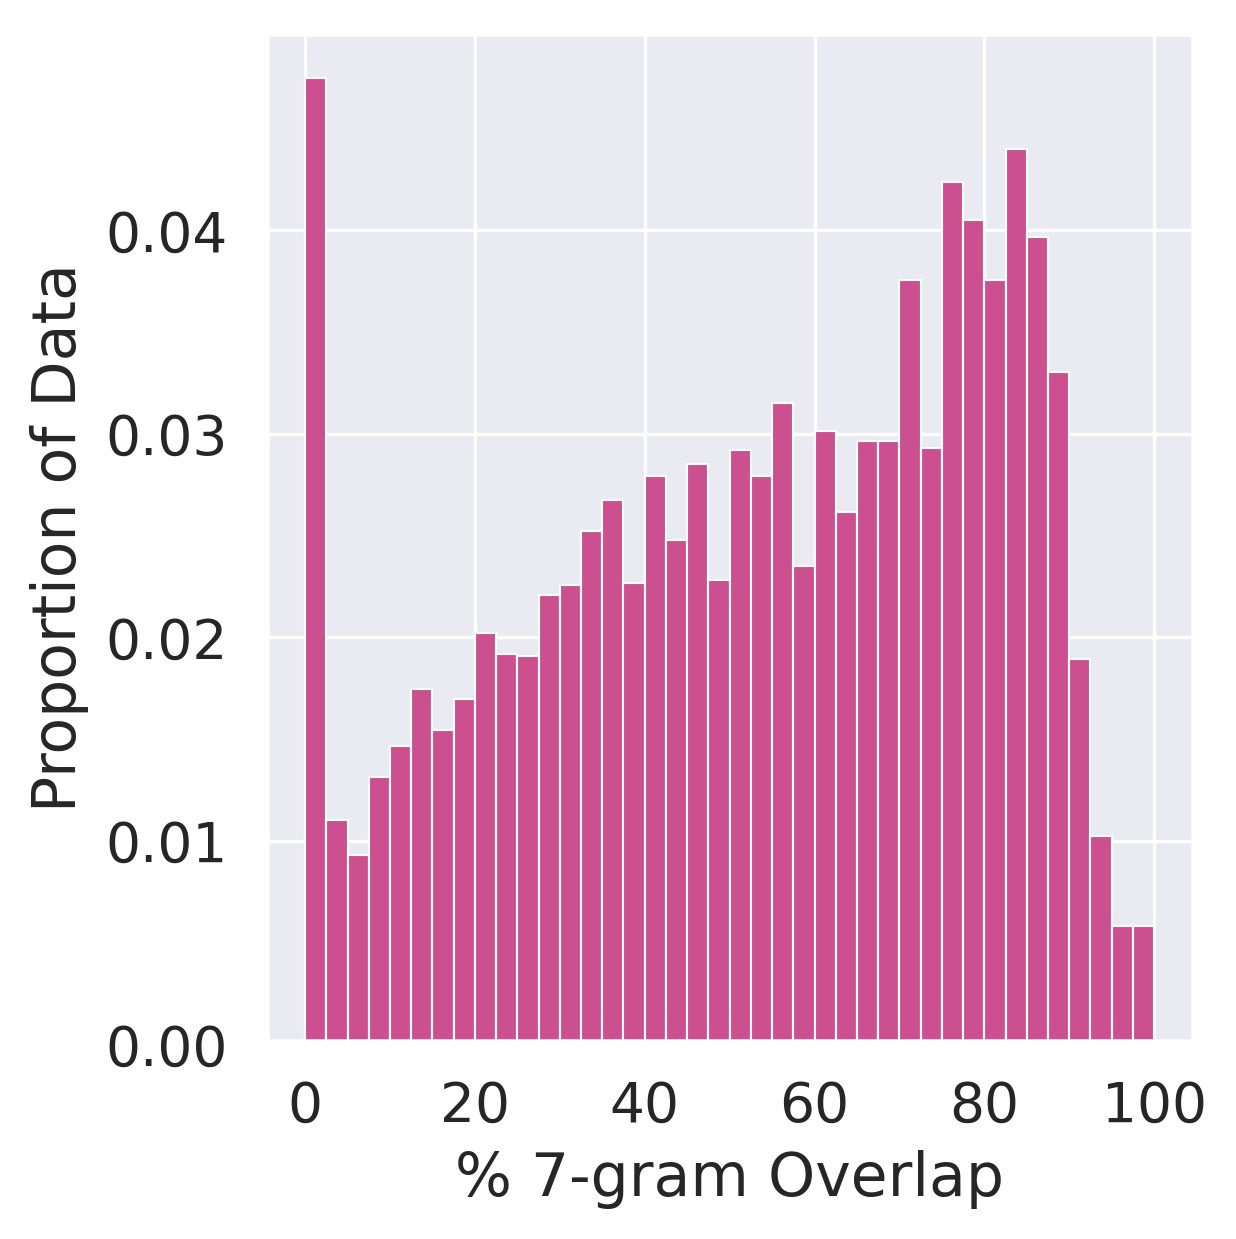

In [19]:
subsets = ["github"]
ngrams = ["ngram_7"]#, "ngram_13"]
# Set Seaborn style
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 5, 'lines.linewidth': 3, 'axes.linewidth': 3})
subset_color_map = ['#fc8d62']
subset_name_map = ['GitHub']

# Create a figure and axis
fig, axs = plt.subplots(len(ngrams), len(subsets), figsize=(4,4 * len(ngrams)),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

thirteen_gram_overlap = [(text, overlap) for text, overlap in subset_overlaps['ngram_13']['github'].items() if overlap < 0.8]
seven_gram_overlap = [subset_overlaps['ngram_7']['github'][text] for text, _ in thirteen_gram_overlap]
print(len(thirteen_gram_overlap))
print(len(seven_gram_overlap))
# for i, ngram in enumerate(ngrams):
#     for j, subset in enumerate(subsets):
#         x_loc, y_loc = i, j
#         curr_axs = axs[j] if len(ngrams) == 1 else axs[x_loc, y_loc]

#         # Plot the histogram
#         ino = subset_overlaps[ngram][subset]
hplt = sns.histplot(ax=axs, data=100 * np.array(seven_gram_overlap), bins=40,
                    # facecolor=subset_color_map[0],
                    facecolor=NGRAM_COLOR,
                    stat='probability')
# #         if x_loc == 0 and y_loc == 0:    
# #             curr_axs.set_ylabel("7-gram")
# #         elif x_loc == 1 and y_loc == 0:    
# #             curr_axs.set_ylabel("13-gram")
# #         else:
axs.set_xlabel('% 7-gram Overlap') #'% Overlap'
axs.set_ylabel('Proportion of Data')

#         if x_loc == 0:
#             curr_axs.set_title(subset_name_map[j])
#         #axs[x_loc, y_loc]
axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
#         if subset == 'github':
#             curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#         else:
#             curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# #         hplt.legend_.remove()
#         # plt.hist(individual_ngram_overlap_values, bins=100, range=(0, 1))

# Save the histograms
plt.savefig("change_ngram_overlap_hist_github.pdf", bbox_inches='tight')

## ngram overlap vs score (needs results folder with MIA scores)

In [ ]:
import argparse
import json 
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
from tqdm import tqdm

# NGRAM_METADATA = "ngram_metadata.json"
ATTACKS = [
    "likelihood_threshold_results.json",
    "ref_model_gpt2_lira_ratio_threshold_results.json",
    "min_prob_k_results.json",
#     "zlib_entropy_threshold_results.json"
]

# ATTACKS = [
#     "loss_results.json",
#     "ref-gpt2_results.json",
#     "min_k_results.json",
#     "zlib_results.json"
# ]

ATTACK_NAMES = [
    "LOSS",
    "Reference-based",
    "Min-k% Prob",
    "Zlib"
]
    
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 5, 'lines.linewidth': 3, 'axes.linewidth': 3})

charts = [
#     {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/wikipedia_(en)", "subset_raw": "wikipedia_(en)", "subset": "Wikipedia", "ngram": "7-gram", "compute_overlap": True},
    {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/github", "subset_raw": "github", "subset": "GitHub", "ngram": "7-gram", "compute_overlap": True},
    {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/arxiv", "subset_raw": "arxiv", "subset": "ArXiv", "ngram": "7-gram", "compute_overlap": True},
     {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/hackernews", "subset_raw": "hackernews", "subset": "HackerNews", "ngram": "7-gram", "compute_overlap": True},
]

# charts = [
#     {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/wikipedia_(en)/test_text.jsonl", "subset_raw": "wikipedia_(en)", "subset": "Wikipedia", "ngram": "13-gram", "compute_overlap": False},
#     {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/github/test_text.jsonl", "subset_raw": "github", "subset": "GitHub", "ngram": "13-gram", "compute_overlap": False},
#         {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/arxiv/test_text.jsonl", "subset_raw": "arxiv", "subset": "ArXiv", "ngram": "13-gram", "compute_overlap": False},
#         {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/hackernews/test_text.jsonl", "subset_raw": "hackernews", "subset": "HackerNews", "ngram": "13-gram", "compute_overlap": False},
# ]
# charts = [
#     {"path": "/gscratch/h2lab/micdun/bff/deduped/temporal_arxiv/ngram_7/arxiv_2023-06", "subset_raw": "temporal_arxiv", "subset": "Temporal ArXiv - 2023/06", "ngram": "7-gram", "compute_overlap": True},
#     {"path": "/gscratch/h2lab/micdun/bff/deduped/temporal_arxiv/ngram_7/arxiv_2023-06", "subset_raw": "temporal_arxiv", "subset": "Temporal ArXiv - 2023/06", "ngram": "7-gram", "compute_overlap": True},
# ]

# Create a figure and axis
fig, axs = plt.subplots(len(ATTACKS), len(charts), figsize=(len(ATTACKS) * 7,len(charts) * 4),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')
color_map = {
    "Wikipedia": "#c2a5cf",
    "GitHub": "#a6dba0",
    "ArXiv": "#386cb0",
    "HackerNews": "#fdc086",
    "WikiMIA": "#c2a5cf",
    "Temporal ArXiv - 2023/06": "#fdc086"
}

threshold = 1

def get_ngram_overlap(shard_0_file, shard_1_file):
    shard_0 = datasets.load_dataset("json", data_files=shard_0_file, split="train")
    print(shard_0)
    shard_1 = datasets.load_dataset("json", data_files=shard_1_file, split="train")
    ngram_inclusion = [np.array(in0) | np.array(in1) for in0, in1 in zip(shard_0["ngram_inclusion"], shard_1["ngram_inclusion"])]
    return [(i, np.mean(d[:200])) for i, d in enumerate(ngram_inclusion) if np.mean(d[:200]) <= threshold]

for i, chart in enumerate(charts):
    if chart["compute_overlap"]:
        print("computing overlap for", chart)
        shard_0_f = os.path.join(chart["path"], "0", "test_raw.jsonl.gz") #test_raw.jsonl.gz  "WikiMIA128_nonmembers.jsonl.gz"
        shard_1_f = os.path.join(chart["path"], "1", "test_raw.jsonl.gz")
        ngram_overlap = get_ngram_overlap(shard_0_f, shard_1_f)
    else:
        print("existing overlap for", chart)
        ngram_metadata_file = chart["path"]
        ngram_metadata_ds = datasets.load_dataset("json", data_files=ngram_metadata_file, split="train")
        ngram_overlap = [(i, o) for i, o in enumerate(ngram_metadata_ds["overlap"]) if o <= threshold]
    
    indices = [i for i, o in ngram_overlap]
    ngram_overlap = [o for i, o in ngram_overlap]
    

    nonmember_overlap = np.array(ngram_overlap) * 100
    
    for j, attack in enumerate(ATTACKS):
        ax = axs[j, i]
#         results_dir = "/mmfs1/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5_temporal_arxiv/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-arxiv_2023_06/"
        results_dir = f"/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-{chart['subset_raw']}_ngram_13_<0.8_truncated/"
        # Load results dictionaries
        f_attack = open(f'{results_dir}/{attack}')
        attack_dict = json.load(f_attack)

        nonmember_scores = np.array(attack_dict["predictions"]["nonmembers"])[indices] # old: nonmembers, new: nonmember
#         member_scores = np.array(attack_dict["predictions"]["members"])

        # pearson r
        r, p = stats.pearsonr(nonmember_overlap, nonmember_scores)

        # Fit a 1st degree polynomial (a line) to the data
        m, c = np.polyfit(nonmember_overlap, nonmember_scores, 1)

        # Generate y-values for the line of best fit
        x_fit = np.arange(0,101,1)
        y_fit = m * x_fit + c

        # Scatter plot
        ax.scatter(nonmember_overlap, nonmember_scores, alpha=0.5, c=color_map[chart["subset"]], cmap='hot',label = 'nonmember')
#         ax.scatter([100] * len(member_scores), member_scores, alpha=0.25, c='red', cmap='hot',label = 'member')
        # Plot the line of best fit
        ax.plot(x_fit, y_fit, c='black', linestyle="--", linewidth="1" )
#         ax.set_xlabel(f"% {chart['ngram']} overlap")
#         ax.set_xlabel(f"% {chart['ngram']} overlap")
        if j == 0:
            ax.set_title(f"{chart['subset']}", fontsize=24)
        if i == 0:
            ax.set_ylabel(ATTACK_NAMES[j], fontsize=20)
        ax.annotate('$r$ = {:.3f}'.format(r), xy=(0.80, 0.85), xycoords='axes fraction')
fig.supxlabel(f"% 7-gram overlap", fontsize=24)

In [ ]:
# ngram overlap of a specific attack
subset = "arxiv"
ref_model = "pythia-1.4b-deduped" #"stablelm-base-alpha-3b-v2"
result_path = f"/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5_ref_tab1_v2/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-{subset}_ngram_13_<0.8_truncated/ref-{ref_model}_results.json"
ngram_overlap_path = f"/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/{subset}"

# Get non-member overlap
def get_ngram_overlap(shard_0_file, shard_1_file):
    shard_0 = datasets.load_dataset("json", data_files=shard_0_file, split="train")
    print(shard_0)
    shard_1 = datasets.load_dataset("json", data_files=shard_1_file, split="train")
    ngram_inclusion = [np.array(in0) | np.array(in1) for in0, in1 in zip(shard_0["ngram_inclusion"], shard_1["ngram_inclusion"])]
    return [(i, np.mean(d[:200])) for i, d in enumerate(ngram_inclusion) if np.mean(d[:200]) <= threshold]

print("computing overlap for", chart)
shard_0_f = os.path.join(ngram_overlap_path, "0", "test_raw.jsonl.gz")
shard_1_f = os.path.join(ngram_overlap_path, "1", "test_raw.jsonl.gz")
nonmember_overlap = get_ngram_overlap(shard_0_f, shard_1_f)
nonmember_overlap = [overlap * 100 for _, overlap in nonmember_overlap]


# Get non-member scores
with open(result_path, 'r') as f:
    metadata = json.load(f)
    nonmember_scores = metadata['predictions']['nonmember']
    sorted_scores = sorted(enumerate(nonmember_scores), key=lambda a: a[1], reverse=True)
    print(sorted_scores[:10])

r, p = stats.pearsonr(nonmember_overlap, nonmember_scores)

# Fit a 1st degree polynomial (a line) to the data
m, c = np.polyfit(nonmember_overlap, nonmember_scores, 1)

# Generate y-values for the line of best fit
x_fit = np.arange(0,101,1)
y_fit = m * x_fit + c

# Scatter plot
plt.scatter(nonmember_overlap, nonmember_scores, alpha=0.5, c=color_map[chart["subset"]], cmap='hot',label = 'nonmember')
#         ax.scatter([100] * len(member_scores), member_scores, alpha=0.25, c='red', cmap='hot',label = 'member')
# Plot the line of best fit
plt.plot(x_fit, y_fit, c='black', linestyle="--", linewidth="1" )
#         ax.set_xlabel(f"% {chart['ngram']} overlap")
#         ax.set_xlabel(f"% {chart['ngram']} overlap")
plt.title(f"{subset}", fontsize=24)
plt.ylabel(f"ref-{os.path.basename(result_path)}", fontsize=20)
plt.annotate('$r$ = {:.3f}'.format(r), xy=(0.80, 0.85), xycoords='axes fraction')
    


In [ ]:
# Compare target vs ref scores
sns.set(style="whitegrid")
subset = "wiki"
results_dir = "/mmfs1/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5_temporal_arxiv_v2/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-arxiv_2023_01"
#results_dir = "/mmfs1/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5_linear_tds_hyp_ref/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-24900_25000_pile"#f"/mmfs1/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5_ref_tab1_v2/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-{subset}_ngram_13_<0.8_truncated"
loss_results = "loss_results.json"
ref_results = "ref-stablelm-base-alpha-3b-v2_results.json"
with open(os.path.join(results_dir, loss_results), 'r') as l:
    loss_dict = json.load(l)

with open(os.path.join(results_dir, ref_results), 'r') as r:
    ref_dict = json.load(r)
    
def line_of_best_fit(x, y):
    # Fit a linear regression line
    coefficients = np.polyfit(x, y, 1)
    line = np.poly1d(coefficients)

    return line

def distance_from_line(point, line):
    # Calculate the perpendicular distance from a point to a line
    x, y = point
    a, b = line.coefficients
    distance = np.abs(b * x - y + a) / np.sqrt(b**2 + 1)

    return distance

def rank_by_distance(x, y):
    line = line_of_best_fit(x, y)
    
    # Calculate distances for each point
    distances = [distance_from_line(point, line) for point in zip(x, y)]

    # Rank the points by distance
    ranked_indices = np.argsort(distances)

    return ranked_indices

# for each classification, get target loss and ref score to compute ref loss
for i, c in enumerate(["member", "nonmember"]):
    plt.figure(i)
    target_loss = loss_dict['predictions'][c]
    ref_score = ref_dict['predictions'][c]
    ref_loss = np.subtract(target_loss, ref_score)
    
    plt.scatter(target_loss, ref_loss, alpha=0.5, c='orange', cmap='hot',label = f'{c}')
    plt.xlabel(f"target loss")
    plt.ylabel(f"{ref_results[:-13]} loss")
    plt.title(c)
    
    ranked_indices = rank_by_distance(target_loss, ref_loss)
    
    print(f"{c} top 5 farthest points: {ranked_indices[:5]}")
    
    
# Plot reference attack score histogram
plt.figure(3)
n_bins=100
print(len(ref_dict['predictions']['member']))
print(len(ref_dict['predictions']['nonmember']))
plt.hist(ref_dict['predictions']['member'], bins=n_bins, label='member')
plt.hist(ref_dict['predictions']['nonmember'], bins=n_bins, label='nonmember')
plt.legend()

# ascend = np.argsort(loss_dict['predictions']['member'])
# descend = ascend[::-1] 
# print(descend[:5])
        

## Epoch Count

### Datablations

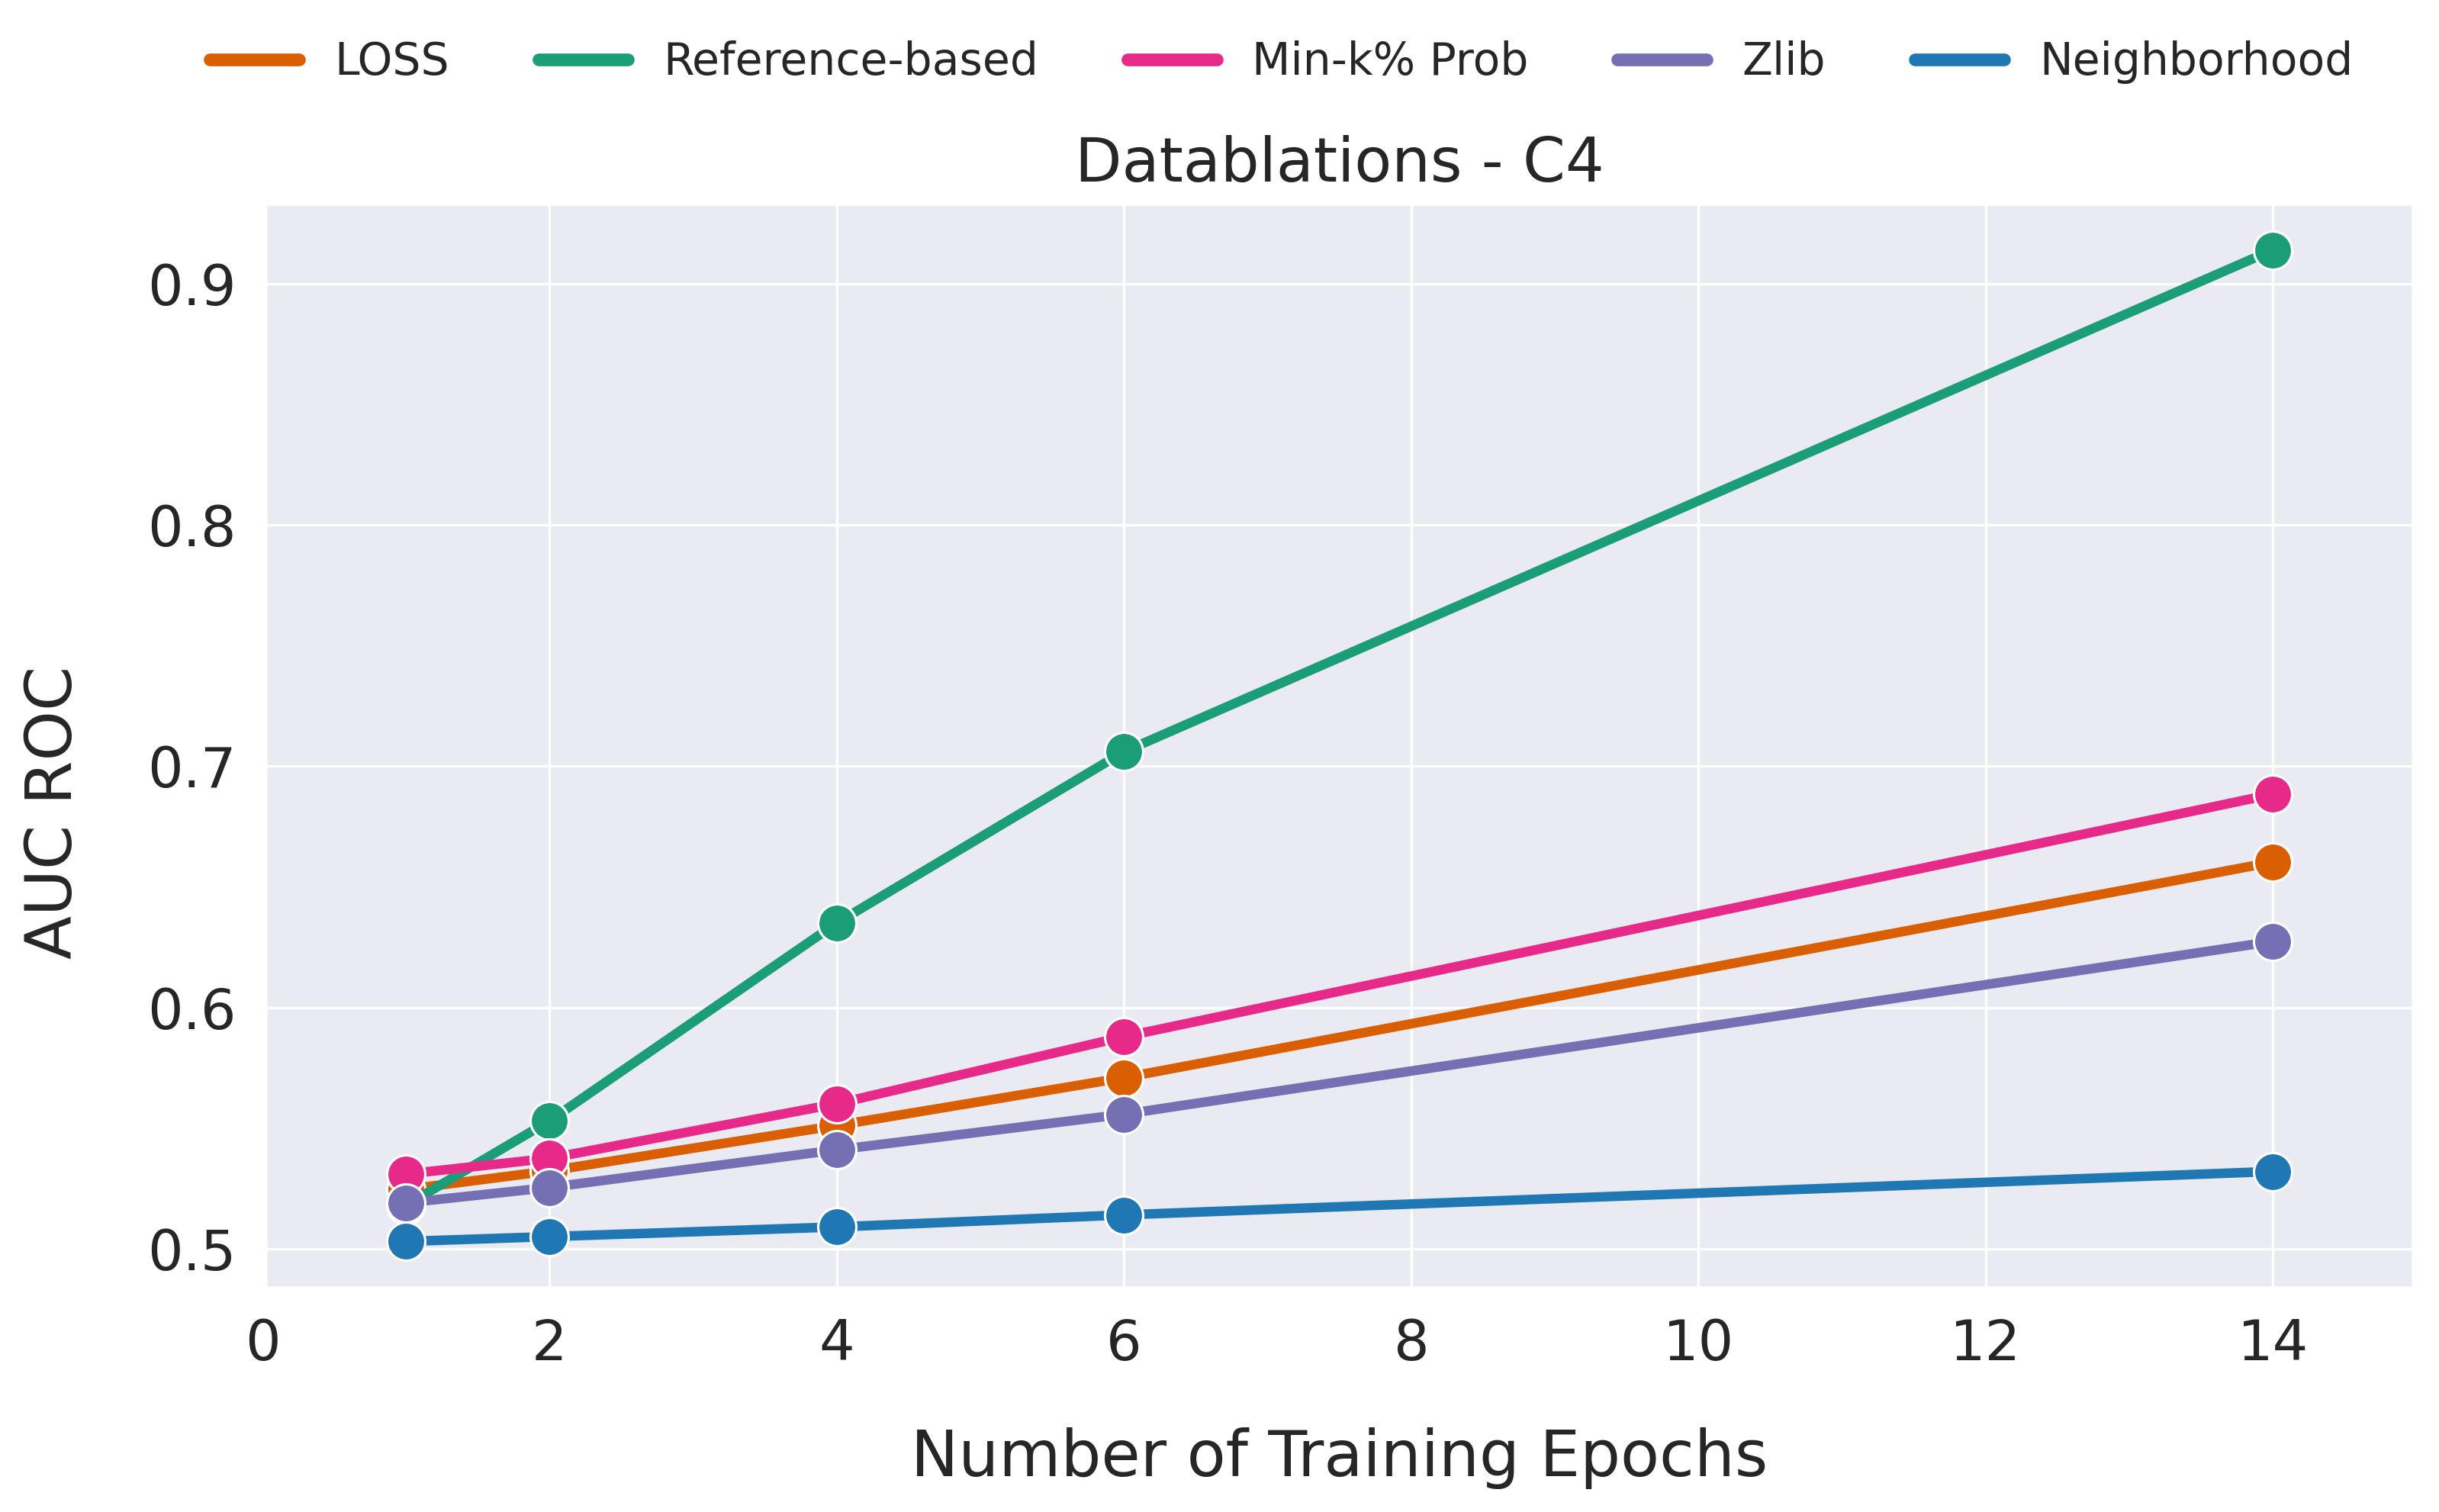

In [39]:
# Datablations - C4 & SILO PDSW semibalanced - HackerNews
fig, axs = plt.subplots(1, 1, figsize=(10,6),gridspec_kw={'wspace':0.1,'hspace':0.1},layout='constrained')
db_epoch_counts = [1,2,4,6,14]
db_loss_score = [0.5245619, 0.5322267, 0.551066, 0.570878, 0.660227]
db_ref_score = [0.518, 0.553, .635, .706, 0.914]
db_mink_score = [0.530927, 0.537447, 0.560082, 0.587850, 0.6883875]
db_zlib_score = [0.518979, 0.525365, 0.540966, 0.5557319, 0.627332]
db_ne_score = [.503, .505, .509, .514, .532]

sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 2, rc={'lines.markersize': 12, 'lines.linewidth': 3, 'axes.linewidth': 3})

db_ax = axs

# Plot the data with Seaborn fro datablations
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_loss_score, marker='o', color=ATTACK_COLOR_MAPPING['loss'])
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_ref_score, marker='o', color=ATTACK_COLOR_MAPPING['ref-stablelm-base-alpha-3b-v2'])
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_mink_score, marker='o', color=ATTACK_COLOR_MAPPING['min_k'])
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_zlib_score, marker='o', color=ATTACK_COLOR_MAPPING['zlib'])
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_ne_score, marker='o', color=ATTACK_COLOR_MAPPING['ne'])
db_ax.set_title('Datablations - C4')

legend_lines, legend_names = [], []
for k, v in ATTACK_COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(ATTACK_MAP[k])
    
db_ax.set_xlim((0, 15))

db_ax.set_xlabel('Number of Training Epochs', fontsize=20)
db_ax.xaxis.set_label_coords(.5, -0.125)
fig.supylabel('AUC ROC', fontsize=20, x=-.05)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.075),
              borderaxespad=0, ncol=5, fontsize=14,
              facecolor='white', frameon=False)

# Save the figure
fig.savefig(f'num_epoch_count_db.pdf', bbox_inches='tight')

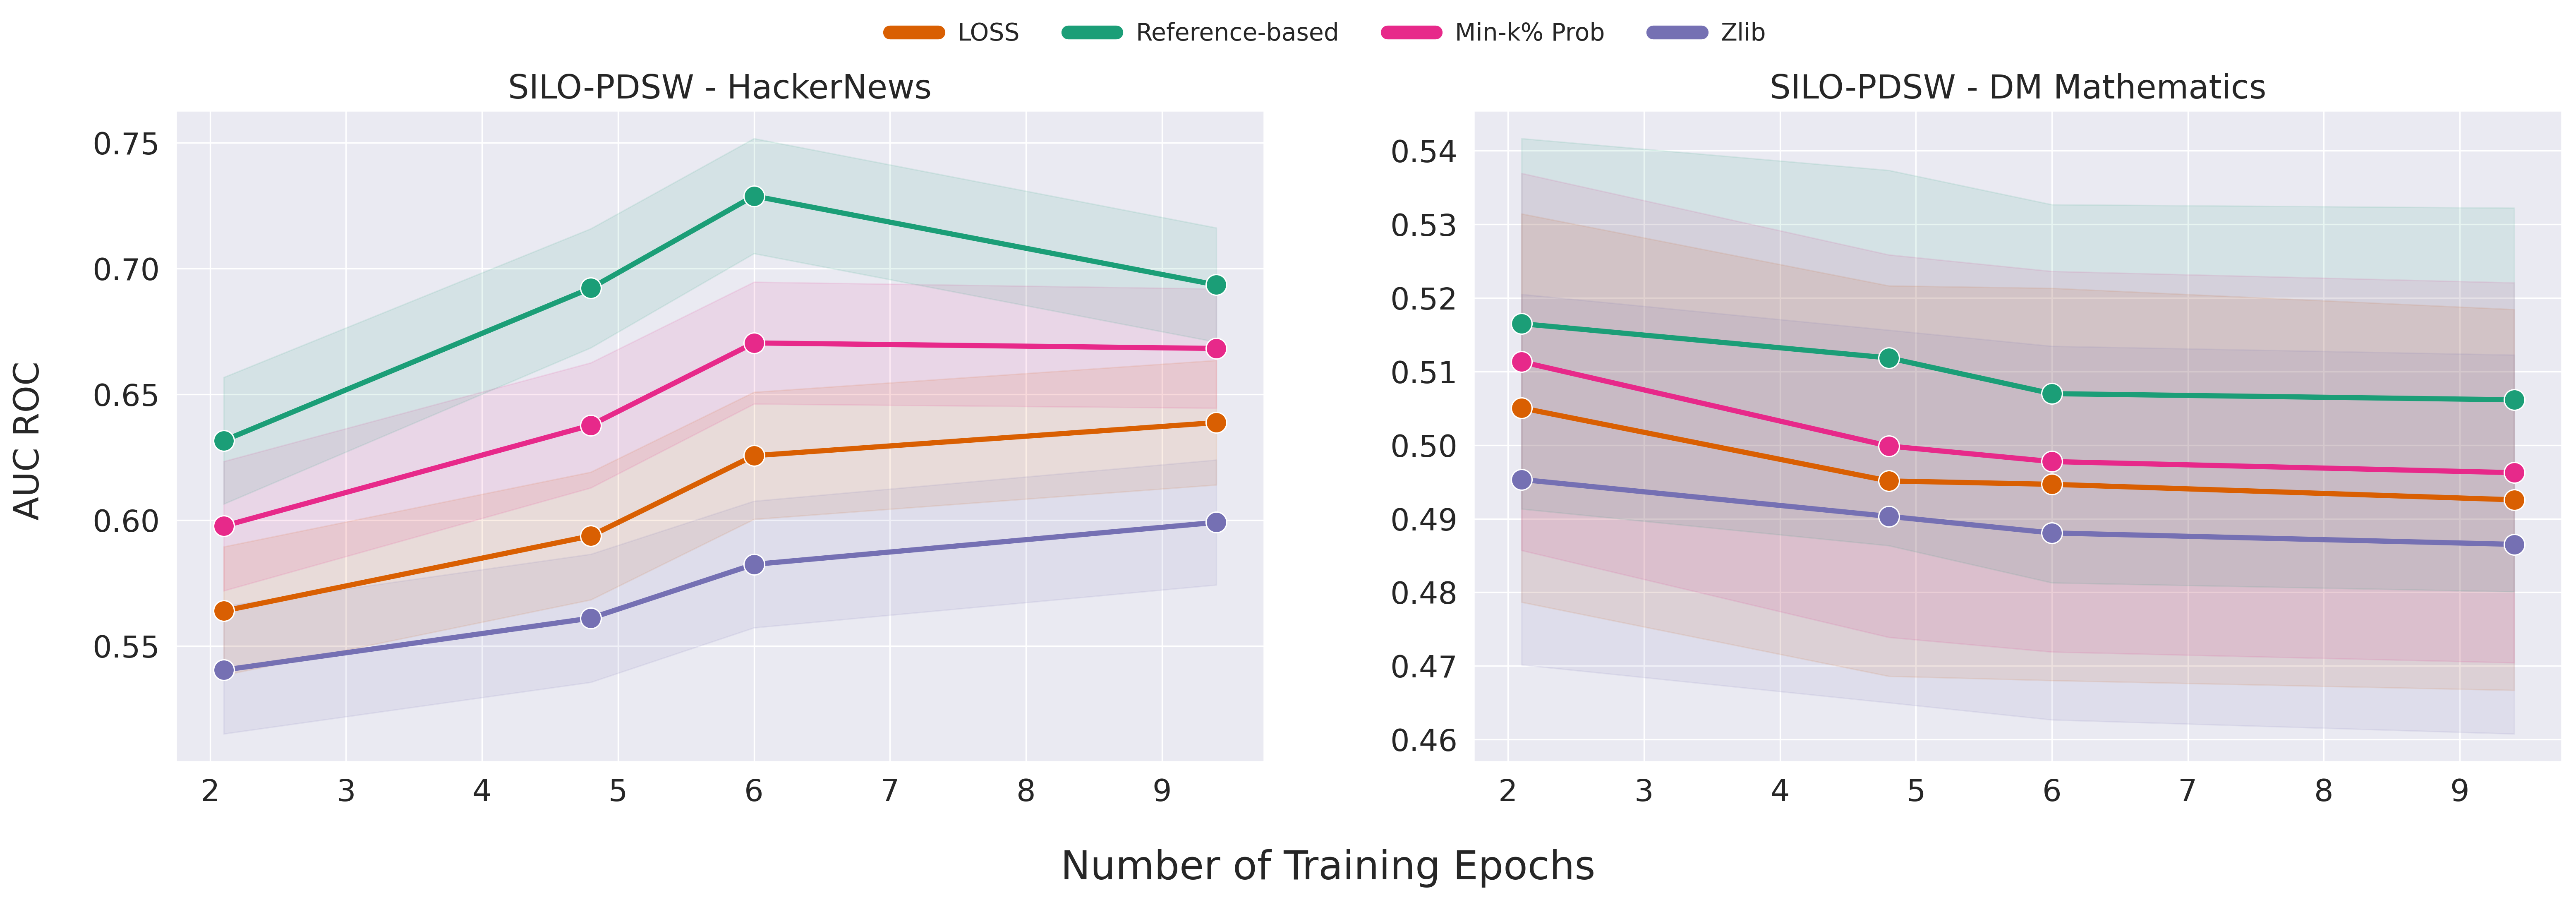

In [71]:
# Datablations - C4 & SILO PDSW semibalanced - HackerNews

# 90, 200, 250, 400
fig, axs = plt.subplots(1, 2, figsize=(10 * 2, 6),gridspec_kw={'wspace':0.1,'hspace':0.1},layout='constrained')

silo_epoch_counts = [2.1, 4.8, 6, 9.4]
silo_loss_score = np.array([0.5639506343702854, 0.59378380636299, 0.6256768024989775, 0.6388294920390598])
silo_ref_score = np.array([.6316440202622903, .6922471640681149, .7289020401099826, .6935604645465471])
silo_mink_score = np.array([0.5976896793722951, 0.6377706011506246, 0.6704800174426697, 0.6682955458242122])
silo_zlib_score = np.array([0.540462384293509, 0.5610871008419431, 0.5824657101592133, 0.5991644155189242])
silo_loss_score_std = np.array([0.01276299217233064, 0.012689973512484055, 0.012630808331877444, 0.012373755417728347])
silo_ref_score_std = np.array([0.01258402473652354, 0.011834054632882033, 0.011429831169543986, 0.011351150776976742])
silo_mink_score_std = np.array([0.012852323444319871, 0.012428297616539144, 0.01211563454828943, 0.01184957830783565])
silo_zlib_score_std = np.array([0.012672869330843694, 0.012727782209947615, 0.012584599509172118, 0.012422998226441167])

# mean values
silo_dm_epoch_counts = [2.1, 4.8, 6, 9.4]
silo_dm_loss_score = np.array([0.5050442787281165, 0.4951302092438392, 0.494672898809211, 0.4925665260299304])
silo_dm_ref_score = np.array([0.5164914445108655, .5118447787547922, .5069891012074713, .5061532134267528])
silo_dm_mink_score = np.array([0.5113125960690379, 0.49987695772801954, 0.4977620919543997, 0.4962532541804649])
silo_dm_zlib_score = np.array([0.49532420978364083, 0.4903203995723673, 0.4880661804185572, 0.4865161019433974])
# std values
silo_dm_loss_score_std = np.array([0.013188971882692498, 0.013259261113156192, 0.01332253203172412, 0.01293265123932586])
silo_dm_ref_score_std = np.array([0.012581165100414547, 0.012746031386781464, 0.012843171982501997, 0.013032216459648326])
silo_dm_mink_score_std = np.array([0.012806177366436387, 0.012990509420885995, 0.012925725550076407, 0.012903739094494103])
silo_dm_zlib_score_std = np.array([0.012583572104066318, 0.012652967259519051, 0.012689699493747065, 0.012868451885071835])



sns.set(style="darkgrid")
sns.set_context("paper",
                font_scale = 2,
                rc={
                    'lines.markersize': 12,
                    'lines.linewidth': 3,
                    'axes.linewidth': 3})

silo_ax = axs[0]
silo_dm_ax = axs[1]


### Hackernews
sns.lineplot(ax=silo_ax, x=silo_epoch_counts, y=silo_loss_score, marker='o', color=ATTACK_COLOR_MAPPING['loss'])
# Add shaded error area (95% CI)
silo_ax.fill_between(silo_epoch_counts, silo_loss_score - 2 * silo_loss_score_std, silo_loss_score + 2 * silo_loss_score_std, color=ATTACK_COLOR_MAPPING['loss'], alpha=0.1)

sns.lineplot(ax=silo_ax, x=silo_epoch_counts, y=silo_mink_score, marker='o', color=ATTACK_COLOR_MAPPING['min_k'])
# Add shaded error area (95% CI)
silo_ax.fill_between(silo_epoch_counts, silo_mink_score - 2 * silo_mink_score_std, silo_mink_score + 2 * silo_mink_score_std, color=ATTACK_COLOR_MAPPING['min_k'], alpha=0.1)

sns.lineplot(ax=silo_ax, x=silo_epoch_counts, y=silo_ref_score, marker='o', color=ATTACK_COLOR_MAPPING['ref-stablelm-base-alpha-3b-v2'])
# Add shaded error area (95% CI)
silo_ax.fill_between(silo_epoch_counts, silo_ref_score - 2 * silo_ref_score_std, silo_ref_score + 2 * silo_ref_score_std, color=ATTACK_COLOR_MAPPING['ref-stablelm-base-alpha-3b-v2'], alpha=0.1)

sns.lineplot(ax=silo_ax, x=silo_epoch_counts, y=silo_zlib_score, marker='o', color=ATTACK_COLOR_MAPPING['zlib'])
# Add shaded error area (95% CI)
silo_ax.fill_between(silo_epoch_counts, silo_zlib_score - 2 * silo_zlib_score_std, silo_zlib_score + 2 * silo_zlib_score_std, color=ATTACK_COLOR_MAPPING['zlib'], alpha=0.1)
silo_ax.set_title('SILO-PDSW - HackerNews')


### DM MATH
sns.lineplot(ax=silo_dm_ax, x=silo_epoch_counts, y=silo_dm_loss_score, marker='o', color=ATTACK_COLOR_MAPPING['loss'])
# Add shaded error area (95% CI)
silo_dm_ax.fill_between(silo_epoch_counts, silo_dm_loss_score - 2 * silo_dm_loss_score_std, silo_dm_loss_score + 2 * silo_dm_loss_score_std, color=ATTACK_COLOR_MAPPING['loss'], alpha=0.1)

sns.lineplot(ax=silo_dm_ax, x=silo_epoch_counts, y=silo_dm_mink_score, marker='o', color=ATTACK_COLOR_MAPPING['min_k'])#, label='LOSS')
# Add shaded error area (95% CI)
silo_dm_ax.fill_between(silo_epoch_counts, silo_dm_mink_score - 2 * silo_dm_mink_score_std, silo_dm_mink_score + 2 * silo_dm_mink_score_std, color=ATTACK_COLOR_MAPPING['min_k'], alpha=0.1)

sns.lineplot(ax=silo_dm_ax, x=silo_epoch_counts, y=silo_dm_ref_score, marker='o', color=ATTACK_COLOR_MAPPING['ref-stablelm-base-alpha-3b-v2'])
# Add shaded error area (95% CI)
silo_dm_ax.fill_between(silo_epoch_counts, silo_dm_ref_score - 2 * silo_dm_ref_score_std, silo_dm_ref_score + 2 * silo_dm_ref_score_std, color=ATTACK_COLOR_MAPPING['ref-stablelm-base-alpha-3b-v2'], alpha=0.1)

sns.lineplot(ax=silo_dm_ax, x=silo_epoch_counts, y=silo_dm_zlib_score, marker='o', color=ATTACK_COLOR_MAPPING['zlib'])
# Add shaded error area (95% CI)
silo_dm_ax.fill_between(silo_epoch_counts, silo_dm_zlib_score - 2 * silo_dm_zlib_score_std, silo_dm_zlib_score + 2 * silo_dm_zlib_score_std, color=ATTACK_COLOR_MAPPING['zlib'], alpha=0.1)

silo_dm_ax.set_title('SILO-PDSW - DM Mathematics')

# Hackernews
silo_ax.set_xticks(np.arange(2, 10, 1))
# silo_ax.set_yticks(np.arange(.5, .8, .05))
# silo_ax.set_ylim((.49, .76))
# DM Math
silo_dm_ax.set_xticks(np.arange(2, 10, 1))
# silo_dm_ax.set_yticks(np.arange(.48, .53, .01))
# silo_dm_ax.set_ylim((.478, .522))

legend_lines, legend_names = [], []
for k, v in ATTACK_COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=8))
    legend_names.append(ATTACK_MAP[k])

x_ax = fig.supxlabel('Number of Training Epochs', y=-.1)
y_ax = fig.supylabel('AUC ROC', fontsize=20, x=-.03)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.075),
              borderaxespad=0, ncol=5, fontsize=14,
              facecolor='white', frameon=False)

# Save the figure
fig.savefig('num_epoch_count_silo.pdf', bbox_inches='tight')

## Training Data Size

In [ ]:
from collections import defaultdict
# Pythia deduped data size exp

datasizes = [
    1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000,
    55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 99000]

# Collect results for graphing
results_file = './mia_unified_mia_v5_linear_tds_recency_hyp_results.json' #'/gscratch/h2lab/micdun/mimir/local/mia_unified_mia_v5_linear_tds_hyp_ref_results.json'
with open(results_file, 'r') as f:
    results = json.load(f)
    
# Reorganize results into a dictionary in the format attack -> model_size -> ckpt -> auc 
organized_results = defaultdict(lambda: defaultdict(dict))
for ckpt, results_per_model_size in results.items():
    ckpt_num = int(ckpt.split('_')[1])
    for msr in results_per_model_size:
        model = msr['target']
        model_size = model.split('-')[1]
        for attack, performance in msr.items():
            if attack != 'target':
                attack_name = attack.split('_results.json')[0]
                roc_auc = performance['roc_auc']
                organized_results[attack_name][model_size][ckpt_num] = roc_auc
                
# Attach ref results from separate run
other_results_file = '/gscratch/h2lab/micdun/mimir/local/mia_unified_mia_v5_linear_tds_recency_hyp_ref_results.json'
with open(other_results_file, 'r') as f:
    other_results = json.load(f)
    
for ckpt, results_per_model_size in other_results.items():
    ckpt_num = int(ckpt.split('_')[1])
    for msr in results_per_model_size:
        model = msr['target']
        model_size = model.split('-')[1]
        for attack, performance in msr.items():
            if attack != 'target' and attack not in organized_results:
                attack_name = attack.split('_results.json')[0]
                roc_auc = performance['roc_auc']
                organized_results[attack_name][model_size][ckpt_num] = roc_auc
                
# print(organized_results['ref-gpt2'])
# print(len(organized_results['ref-gpt2']['1.4b']))

sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 2,
                rc={'lines.markersize': , 'lines.linewidth': 3, 'axes.linewidth': 3})

# attacks_look_at = ['min_k']
attacks_look_at = ['loss', 'ref-stablelm-base-alpha-3b-v2', 'min_k', 'zlib']

# Create a figure and axis
# fig, axs = plt.subplots(1, len(attacks_look_at), figsize=(10 * len(attacks_look_at), 6),
#                         gridspec_kw={'wspace':0.05,'hspace':0.05},
#                         layout='constrained')
fig, axs = plt.subplots(math.ceil(len(attacks_look_at) / 2), 2, figsize=(9 * math.ceil(len(attacks_look_at) / 2), 8),
                        gridspec_kw={'wspace':0.05,'hspace':0.05},
                        layout='constrained')
if len(attacks_look_at) == 1:
    axs = np.expand_dims(axs, 0)

for i, attack in enumerate(attacks_look_at):
    results = organized_results[attack]
    current_axs = axs[i // 2, i % 2] #axs[i]

    for model_size, performance_per_ckpt in results.items():
        performance = [performance_per_ckpt[d] for d in datasizes]
        sns.lineplot(ax=current_axs, x=datasizes, y=performance, color=MODEL_SIZE_COLOR_MAPPING[model_size], marker='o')

    if len(attacks_look_at) > 1:
        current_axs.set_title(ATTACK_MAP[attack], fontsize=20)
    current_axs.set_ylim((0.47, .81)) #(0.48, 0.77) #(0.47, .95)
    current_axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if len(attacks_look_at) == 1:
    axs[0].set_xlabel('Number of Training Steps', fontsize=20)
    axs[0].xaxis.set_label_coords(.5, -0.125)
else:
    fig.supxlabel('Number of Training Steps', fontsize=24, y=-.075)
fig.supylabel('AUC ROC', fontsize=24, x=-.025) #fig.supylabel('AUC ROC', fontsize=20, x=-.05)

legend_lines, legend_names = [], []
for k, v in MODEL_SIZE_COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(k.upper())

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.075),
              borderaxespad=0, ncol=4, fontsize=18,
              facecolor='white', frameon=False)

# # Legend plot
# plt.figlegend(legend_lines, legend_names,
#               loc='upper center', bbox_to_anchor=(0.5, 1.05),
#               borderaxespad=0, ncol=2, fontsize=12)

# Save the figure
fig.savefig(f'recency.pdf', bbox_inches='tight')

## Special MIA: Temporal ArXiv

In [22]:
from collections import defaultdict
# Pythia deduped data size exp

dates = ['2020-08', '2021-01', '2021-06', '2022-01', '2022-06', '2023-01', '2023-06']

# Collect results for graphing
results_file = './mia_unified_mia_v5_temporal_arxiv_v2_results.json'
with open(results_file, 'r') as f:
    results = json.load(f)
    
# Reorganize results into a dictionary in the format attack -> timestamp -> auc 
organized_results = defaultdict(dict)
for ts, results in results.items():
    ts = '-'.join(ts.split('_')[1:])
    r = results[0]
    for attack, performance in r.items():
        if attack != 'target':
            attack_name = attack.split('_results.json')[0]
            roc_auc = performance['roc_auc']
            organized_results[attack_name][ts] = roc_auc

# print(organized_results)

sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.6, rc={'lines.markersize': 10, 'lines.linewidth': 3, 'axes.linewidth': 3})

# Create a figure and axis
fig, axs = plt.subplots(1, 1, figsize=(10,6),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, (attack, results) in enumerate(organized_results.items()):
    performance = [results[d] for d in dates]
    sns.lineplot(ax=axs, x=dates, y=performance, color=ATTACK_COLOR_MAPPING[attack], marker='o')

# # Add NE results
ne_performance = [.625, .612, .637, .629, .649, .631, .649]
sns.lineplot(ax=axs, x=dates, y=ne_performance, color=ATTACK_COLOR_MAPPING['ne'], marker='o')


axs.set_ylim((0.6, 0.82))
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.set_yticks(np.arange(.6, .85, .05))
    
axs.set_xlabel('Timestamp', fontsize=20)
axs.xaxis.set_label_coords(.5, -.15)
axs.set_ylabel('AUC ROC', fontsize=20)
axs.yaxis.set_label_coords(-.1, .5)

legend_lines, legend_names = [], []
for k, v in ATTACK_COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(ATTACK_MAP[k])

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.50, 1.1),
              borderaxespad=0, ncol=5, fontsize=14,
              facecolor='white', frameon=False)

# # Legend plot
# plt.figlegend(legend_lines, legend_names,
#               loc='upper center', bbox_to_anchor=(0.5, 1.05),
#               borderaxespad=0, ncol=2, fontsize=12)

# Save the figure
fig.savefig(f'temporal_arxiv.pdf', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: './mia_unified_mia_v5_temporal_arxiv_v2_results.json'

In [ ]:
# Overlap graphs for temporal arxiv
import json 
import os
import datasets
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

ngrams = ["7-gram"]# "13-gram"]
ngram_file_map = {
    "7-gram": "ngram_7",
    "13-gram": "ngram_13"
}
ngram_ylim_map = {
    "7-gram": (0, 0.16),
    "13-gram": (0, 0.9)
}
base_dir = "/gscratch/h2lab/micdun/bff/deduped/temporal_arxiv/" #"/gscratch/h2lab/micdun/bff/deduped/temporal_wiki_full/" 
timestamps = ['2019-01', '2022-01', '2023-01']# ['Temporal Wiki'] 

subset_overlaps_temporal = defaultdict(lambda: defaultdict(dict))
for ngram in ngrams:
    for ts in timestamps:
        shard_0 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram_file_map[ngram], f'arxiv_{ts}', "0", "test_raw.jsonl.gz"), split="train") #, f'arxiv_{ts}' "WikiMIA128_nonmembers.jsonl.gz"
        print(shard_0)
        shard_1 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram_file_map[ngram], f'arxiv_{ts}', "1", "test_raw.jsonl.gz"), split="train")

        assert shard_0["original"][0] == shard_1["original"][0] and shard_0["original"][1] == shard_1["original"][1]
        ngram_inclusion = [np.array(in0) | np.array(in1) for in0, in1 in zip(shard_0["ngram_inclusion"], shard_1["ngram_inclusion"])]
        individual_ngram_overlap = {text: np.mean(d[:200]) for text, d in zip(shard_0["original"], ngram_inclusion)}
        subset_overlaps_temporal[ts][ngram] = individual_ngram_overlap

# Set Seaborn style
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 5, 'lines.linewidth': 3, 'axes.linewidth': 3})
subset_color_map = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
subset_name_map = ['Wikipedia', 'Github', 'Pubmed Central', 'Pile CC']

# Create a figure and axis
fig, axs = plt.subplots(len(ngrams), len(timestamps) + 1, figsize=(len(timestamps)*4 + 4, len(ngrams)*4),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, ngram in enumerate(ngrams):
    for j, ts in enumerate(timestamps):
        curr_axs = axs[j+1] if len(ngrams) == 1 else axs[i, j+1]

        # Plot the histogram
        ino = subset_overlaps_temporal[ts][ngram]
        print(f"{ts}:", np.mean(list(ino.values())))
        hplt = sns.histplot(ax=curr_axs, data=100 * np.array(list(ino.values())), bins=40,
#                             facecolor=subset_color_map[j+1],
                            facecolor=NGRAM_COLOR,
                            stat='probability')

        curr_axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
    #         hplt.legend_.remove()
        curr_axs.set_ylim(ngram_ylim_map[ngram])
        curr_axs.set_ylabel(None)
        if i == 0:
            curr_axs.set_title(f"{ts}")
        else:
            curr_axs.get_yaxis().set_visible(False)
        # plt.hist(individual_ngram_overlap_values, bins=100, range=(0, 1))
        
    # Add original distribution plot
    original_distribution = [overlap for _, overlap in subset_overlaps[ngram_file_map[ngram]]['arxiv'].items()] # wikipedia_(en)
    print("original:", np.mean(original_distribution))
    curr_axs = axs[0] if len(ngrams) == 1 else axs[i, 0]
    
    hplt = sns.histplot(ax=curr_axs, data=100 * np.array(original_distribution), bins=40, facecolor=subset_color_map[0], stat='probability')
    curr_axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
    #         hplt.legend_.remove()
    curr_axs.set_ylim(ngram_ylim_map[ngram])
    curr_axs.set_ylabel('Proportion of Data')
    if i == 0:
        curr_axs.set_title(f"Original")

x_ax = fig.supxlabel('% 7-gram Overlap')
# y_ax = fig.supylabel('Proportion of Data')

# Save the histograms
# plt.savefig(f"temporal_arxiv_{ts}_ngram_overlap_hist.pdf", bbox_inches='tight')
# plt.savefig(f"temporal_wiki_ngram_overlap_hist.pdf", bbox_inches='tight')
# plt.savefig(f"wikimia_ngram_overlap_hist.png", bbox_inches='tight')